In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 1. Prepare data

In [2]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, flip_y=0.01, class_sep=1.5, random_state=42)

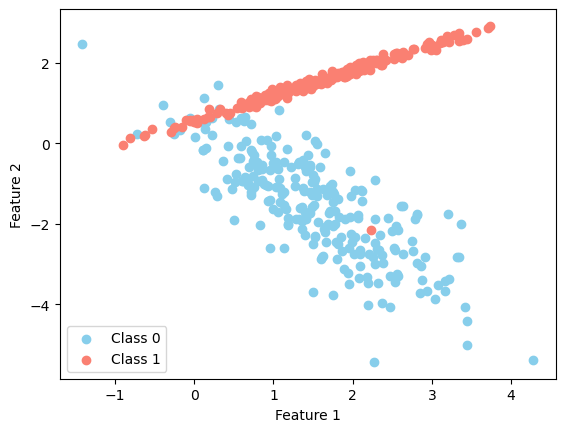

In [6]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='skyblue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='salmon', label='Class 1')
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [11]:
X_train_torch = torch.tensor(X_train_std, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test_std, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_train_tf = tf.convert_to_tensor(X_train_std, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test_std, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32)

# 2. Torch MLp

## 2.1 MLP torch nn.Sequential

In [12]:
model_seq = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_seq.parameters(), lr=0.01)
train_losses_seq = []

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model_seq(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses_seq.append(loss.item())

## 2.2 MLP torch nn.Module

In [15]:
class MyTorchMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, X):
        X = torch.relu(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        return X

model_mod = MyTorchMLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_mod.parameters(), lr=0.01)
train_losses_mod = []

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model_mod(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses_mod.append(loss.item())

## 2.3 Visualize the loss curve

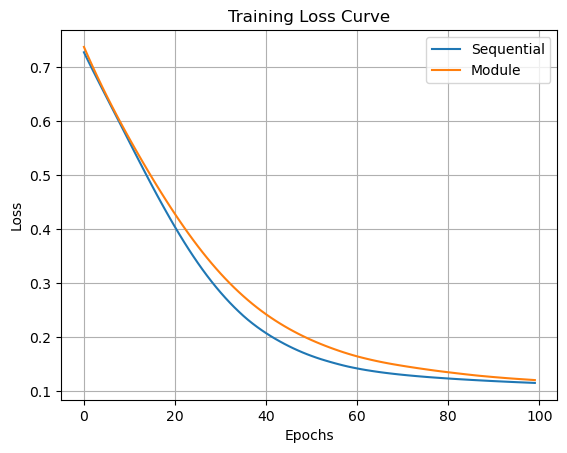

In [16]:
plt.plot(train_losses_seq, label="Sequential")
plt.plot(train_losses_mod, label="Module")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

## 2.4 Plot the decision boundary

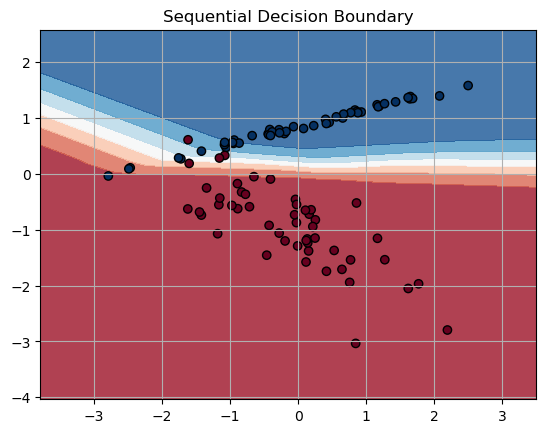

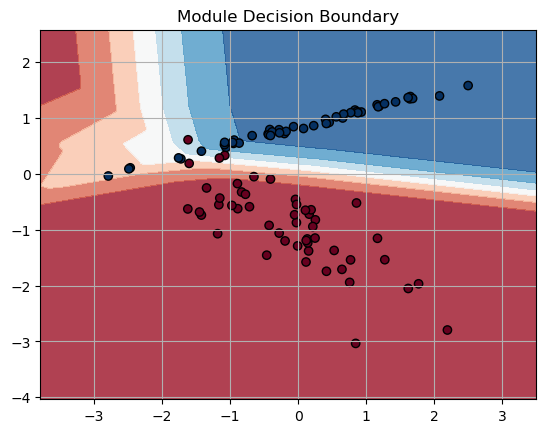

In [24]:
def plot_decision_boundary(model, X, y, title):
    model.eval()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_decision_boundary(model_seq, X_test_torch, y_test_torch, "Sequential Decision Boundary")
plot_decision_boundary(model_mod, X_test_torch, y_test_torch, "Module Decision Boundary")

# 3. TensorFlow MLP

## 3.1 MLP tf.keras.Sequential

In [21]:
model_seq_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(2,)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

train_losses_seq_tf = []

for epoch in range(100):
    with tf.GradientTape() as tape:
        y_pred = model_seq_tf(X_train_tf, training=True)
        loss = loss_fn(y_train_tf, y_pred)

    grads = tape.gradient(loss, model_seq_tf.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_seq_tf.trainable_variables))
    train_losses_seq_tf.append(loss.numpy())

## 3.2 MLP tf.keras.Model

In [22]:
class MyTFMLP(tf.keras.Model):
    def __init__(self):
        super(MyTFMLP, self).__init__()
        self.fc1 = tf.keras.layers.Dense(16, activation='relu')
        self.fc2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return x

model_model = MyTFMLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.BinaryCrossentropy()

train_losses_mod_tf = []

for epoch in range(100):
    with tf.GradientTape() as tape:
        logits = model_model(X_train_tf, training=True)
        loss = loss_fn(y_train_tf, logits)
    grads = tape.gradient(loss, model_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_model.trainable_variables))
    train_losses_mod_tf.append(loss.numpy())

## 3.3 Visualize the loss curve

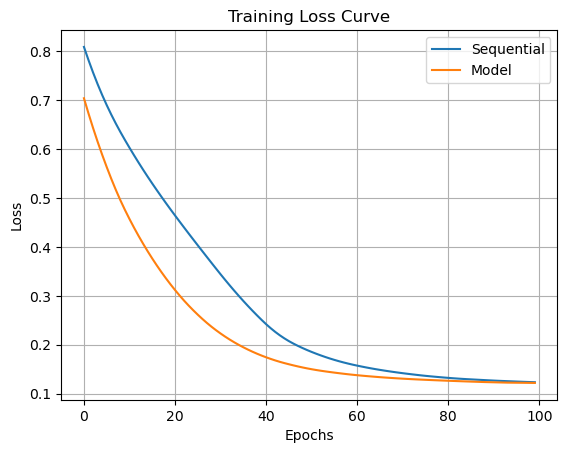

In [23]:
plt.plot(train_losses_seq_tf, label="Sequential")
plt.plot(train_losses_mod_tf, label="Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

## 3.4 Plot Decision Boundary

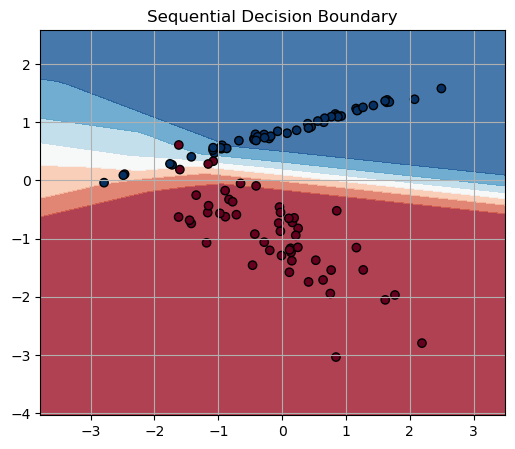

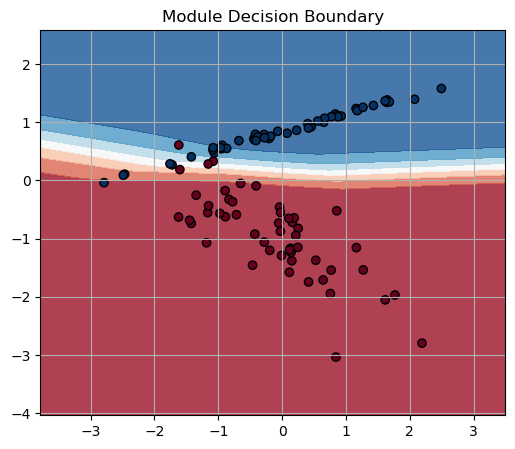

In [26]:

def plot_decision_boundary_tf(model, X, y, title):
     # 若 X 是 Tensor，则转为 NumPy
    if isinstance(X, tf.Tensor):
        X = X.numpy()
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # 构造网格点并预测
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = tf.convert_to_tensor(grid, dtype=tf.float32)
    Z = model(grid_tensor, training=False).numpy().reshape(xx.shape)

    # 绘图
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdBu)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_decision_boundary_tf(model_seq_tf, X_test_tf, y_test_tf, "Sequential Decision Boundary")
plot_decision_boundary_tf(model_model, X_test_tf, y_test_tf, "Module Decision Boundary")